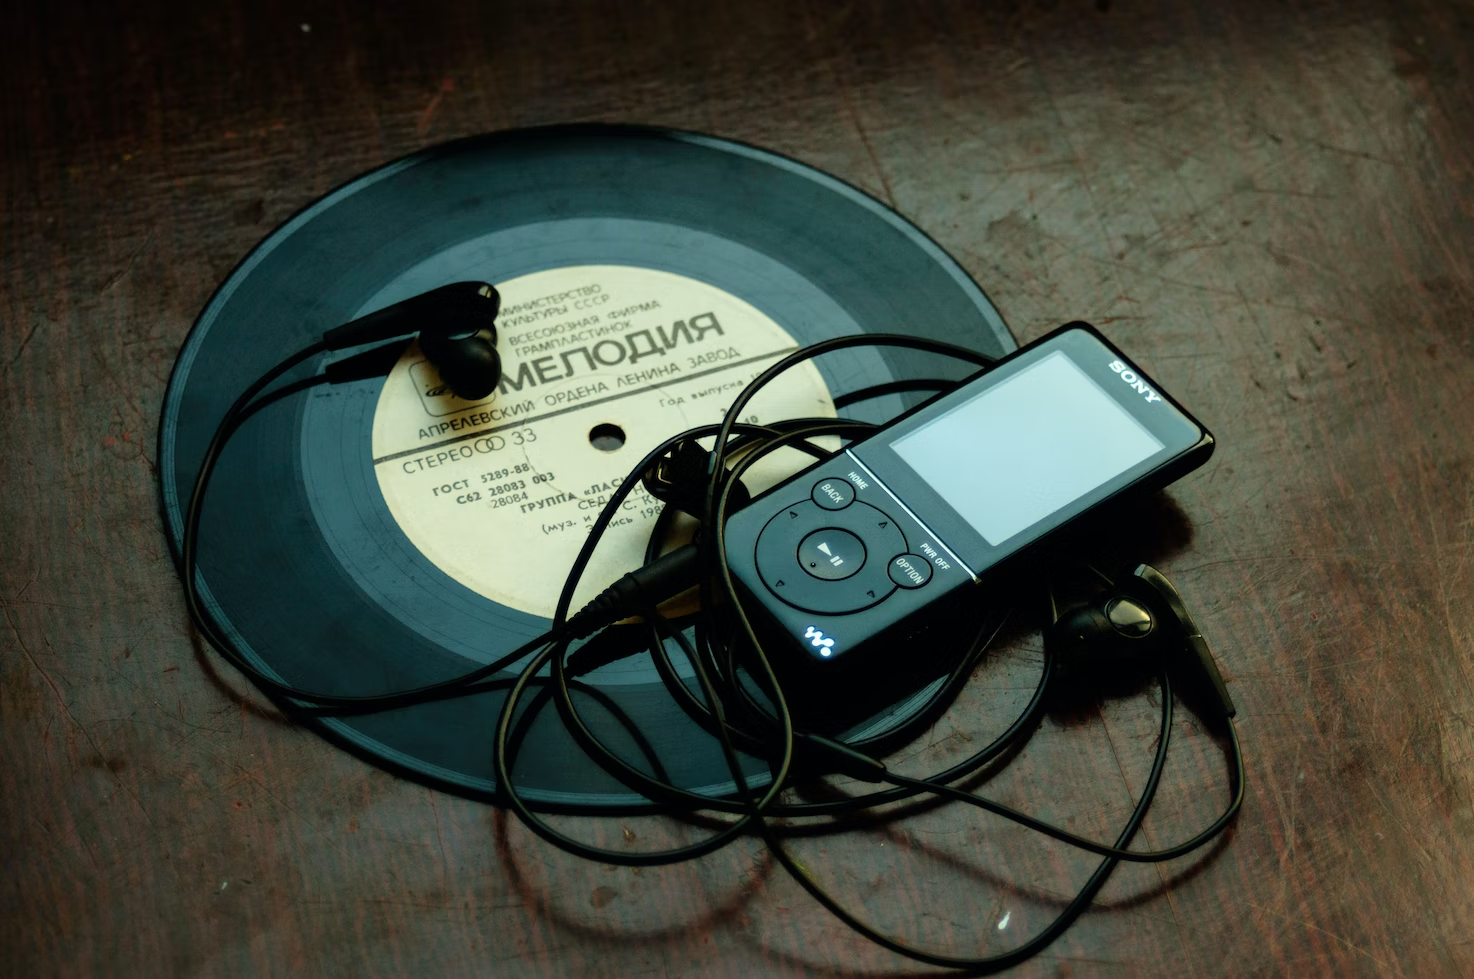

# 프로젝트: 멋진 작사가 만들기
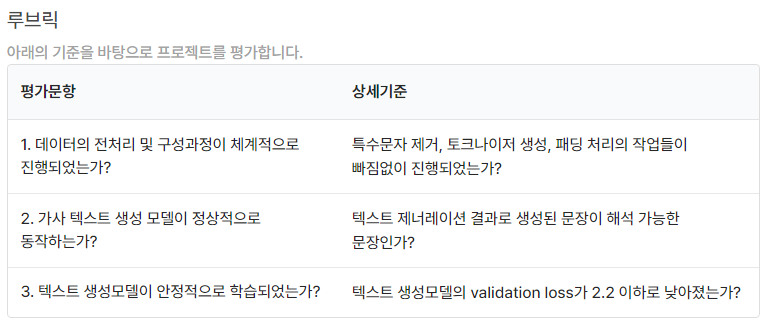

## Step 1. 데이터 읽어오기

In [36]:
import glob # 리스트 형식으로 파일 불러오기 
import os, re 
import numpy as np
import tensorflow as tf

txt_file_path = os.getenv('HOME')+'/aiffel/lyricist/data/lyrics/*' 

txt_list = glob.glob(txt_file_path) 

raw_corpus = [] 

# 텍스트 내용을 모두 raw_corpus 리스트에 담기
for txt_file in txt_list:
    with open(txt_file, "r") as f:
        raw = f.read().splitlines() 
        raw_corpus.extend(raw)

print("데이터 크기:", len(raw_corpus))
print("Examples:\n", raw_corpus[:9])

데이터 크기: 187088
Examples:
 ['', '', '[Spoken Intro:]', 'You ever want something ', "that you know you shouldn't have ", "The more you know you shouldn't have it, ", 'The more you want it ', 'And then one day you get it, ', "It's so good too "]


- read() : 파일 전체의 내용을 하나의 문자열로 읽어옴 
- splitlines()  : 여러라인으로 구분되어 있는 문자열을 한라인씩 분리하여 리스트로 반환
- extend() : 리스트함수로 추가적인 내용을 연장

## Step 2. 데이터 정제

In [38]:
# raw_corpus 리스트의 인덱스와 문장 반환 
for idx, sentence in enumerate(raw_corpus):
    if len(sentence) == 0: continue   # 공백 줄 건너뛰기 
    if sentence[-1] == "]": continue  # 문장의 끝이 : 인 문장은 건너뛰기 

    if idx > 9: break   # 문장 10개 확인 
        
    print(idx, sentence)

3 You ever want something 
4 that you know you shouldn't have 
5 The more you know you shouldn't have it, 
6 The more you want it 
7 And then one day you get it, 
8 It's so good too 
9 But it's just like my girl 


In [4]:
# 대소문자, 공백, 특수문자 처리 후 <start>, <end> 추가 
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip() 
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence) 
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence)
    sentence = sentence.strip() # 5
    sentence = '<start> ' + sentence + ' <end>' 
    return sentence


print(preprocess_sentence("This @_is ;;;sample        sentence."))

<start> this is sample sentence . <end>


In [5]:
# corpus에 정제된 문장을 리스트로 모음
corpus = []

# raw_corpus에 저장된 문장들을 정제해 corpus에 저장
for sentence in raw_corpus:
    if len(sentence) == 0: continue
    if sentence[-1] == "]": continue
    
    preprocessed_sentence = preprocess_sentence(sentence)
    corpus.append(preprocessed_sentence)
        
# 정제된 문장 10개 확인 
corpus[:10]

['<start> you ever want something <end>',
 '<start> that you know you shouldn t have <end>',
 '<start> the more you know you shouldn t have it , <end>',
 '<start> the more you want it <end>',
 '<start> and then one day you get it , <end>',
 '<start> it s so good too <end>',
 '<start> but it s just like my girl <end>',
 '<start> when she s around me <end>',
 '<start> i just feel so good , so good <end>',
 '<start> but right now i just feel cold , so cold <end>']

## Step 3. 평가 데이터셋 분리

In [6]:
# 토큰화 
def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=15000, # 단어사전 15000개로 설정 
        filters=' ',   # 공백 필터링 
        oov_token="<unk>" # 단어사전에 포함되지 못한 단어는 <unk>로 바꿈 
    )
    # 단어장을 완성
    tokenizer.fit_on_texts(corpus)
    
    # 단어장으로 corpus를 Tensor로 변환    
    tensor = tokenizer.texts_to_sequences(corpus)  
    
    # 입력 데이터의 시퀀스 길이 일정하게 맞춤 
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post',maxlen=15)  
    
    print(tensor,tokenizer)
    return tensor, tokenizer

tensor, tokenizer = tokenize(corpus)

[[  2   7 156 ...   0   0   0]
 [  2  17   7 ...   0   0   0]
 [  2   6  98 ...   0   0   0]
 ...
 [  2 310   1 ...   0   0   0]
 [  2 729   5 ...   0   0   0]
 [  2 729   5 ...   0   0   0]] <keras_preprocessing.text.Tokenizer object at 0x7f371a2da6d0>


- tokenizer.fit_on_texts(texts): 문자 데이터를 입력받아 리스트의 형태로 변환하는 메서드
- tokenizer.texts_to_sequences(texts): 텍스트 안의 단어들을 숫자의 시퀀스 형태로 변환하는 메서드
   
Ref.    
https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer 

In [7]:
# 3X10 확인 
print(tensor[:3, :10])

[[   2    7  156   62  199    3    0    0    0    0]
 [   2   17    7   34    7 1536   15   76    3    0]
 [   2    6   98    7   34    7 1536   15   76   11]]


In [8]:
# 단어사전 10개 확인 
for idx in tokenizer.index_word:
    print(idx, ":", tokenizer.index_word[idx])

    if idx >= 10: break

1 : <unk>
2 : <start>
3 : <end>
4 : ,
5 : i
6 : the
7 : you
8 : and
9 : a
10 : to


단어 사전의 2번이 \<start>라서 위의 토큰화시킨 문장에 2가 많다는 것을 알 수 있다. 

In [9]:
# tensor의 <end> 잘라내 소스 문장 생성
src_input = tensor[:, :-1]  

# tensor의 <start> 잘라내 타겟 문장 생성
tgt_input = tensor[:, 1:]    

print(src_input[0])
print(tgt_input[0])

[  2   7 156  62 199   3   0   0   0   0   0   0   0   0   0   0   0   0
   0]
[  7 156  62 199   3   0   0   0   0   0   0   0   0   0   0   0   0   0
   0]


Q. 소스 문장과 타겟 문장을 왜 이렇게 나누는걸까?

A. tensor의 문장이 '\<start> i love you! \<end>'라고 가정하면, <br/>
    소스 문장을 '\<start> i love you!' <br/>
    타겟 문장을 'i love you! \<end> '로 설정해,  <br/>
    input으로 i 넣으면 love가 ouput으로 나오고,  <br/>
    input으로 love 넣으면 you가 ouput으로 나오고,  <br/>
    input으로 you 넣으면 !가 ouput으로 나온다고 학습시키려 하기 때문이다. 

In [10]:
# 데이터셋 만들기 
BUFFER_SIZE = len(src_input)
BATCH_SIZE = 256
steps_per_epoch = len(src_input) // BATCH_SIZE

VOCAB_SIZE = tokenizer.num_words + 1   # 단어장의 단어 15000개 + 0:<pad> = 15001개 

dataset = tf.data.Dataset.from_tensor_slices((src_input, tgt_input))
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
dataset

<BatchDataset shapes: ((256, 19), (256, 19)), types: (tf.int32, tf.int32)>

- BUFFER_SIZE : 샘플의 단위 
- tokenizer.num_words: 주어진 데이터의 문장들에서 빈도수가 높은 n개의 단어    

Ref.     
https://www.tensorflow.org/api_docs/python/tf/data/Dataset 데이터셋 

In [11]:
# train, validation 분리 
from sklearn.model_selection import train_test_split

enc_train, enc_val, dec_train, dec_val = train_test_split(src_input, tgt_input, random_state=2023, test_size=0.2)

print("enc_train shape: {}".format(enc_train.shape))
print("dec_train shape: {}".format(dec_train.shape))
print("enc_val shape: {}".format(enc_val.shape))
print("dec_val shape: {}".format(dec_val.shape))

enc_train shape: (139790, 19)
dec_train shape: (139790, 19)
enc_val shape: (34948, 19)
dec_val shape: (34948, 19)


## Step 4. 인공지능 만들기

In [12]:
# 모델 만들기 
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size) 
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)  
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out

embedding_size = 512  
hidden_size = 1024   
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size) # 단어장의 단어 15000개 + 0:<pad> = 15001개 

- embedding_size : 단어가 추상적으로 표현되는 크기, 클수록 추상적인 특징을 잡아낼 수 있음    
- hidden_size : 모델의 일꾼 수 

In [13]:
# 데이터 한 배치만 샘플로 불러오기
for src_sample, tgt_sample in dataset.take(1): break

# 한 배치를 모델에 넣어보기
model(src_sample)

<tf.Tensor: shape=(256, 19, 15001), dtype=float32, numpy=
array([[[-3.16697173e-04,  1.03122846e-04, -9.28934678e-05, ...,
          2.95229955e-04,  2.70994089e-04, -8.89371149e-05],
        [-2.83350324e-04, -1.21909834e-05, -5.28550532e-04, ...,
          6.57371420e-04,  5.55844803e-04,  2.44358034e-05],
        [-5.51829056e-04, -2.98309198e-04, -8.90537282e-04, ...,
          8.29286932e-04,  8.16453423e-04, -1.17240716e-05],
        ...,
        [-1.82665617e-03,  1.33792555e-03, -3.52532748e-04, ...,
          1.04158756e-03,  3.43902106e-03, -1.15319167e-03],
        [-2.08647014e-03,  1.30900438e-03, -3.06449598e-04, ...,
          1.03027513e-03,  3.83504247e-03, -1.42854929e-03],
        [-2.32157088e-03,  1.28818746e-03, -2.59966619e-04, ...,
          1.02149497e-03,  4.19732230e-03, -1.68045447e-03]],

       [[-3.16697173e-04,  1.03122846e-04, -9.28934678e-05, ...,
          2.95229955e-04,  2.70994089e-04, -8.89371149e-05],
        [-6.58670731e-04,  1.72826083e-04, -1

Q. 기존의 머신러닝, 딥러닝과 달리 샘플을 만드는 이유는 무엇일까?   
A. 초기값이 생겨야 weight가 생성된다. 데이터를 전부 넣어서 모델을 돌리면 시간이 매우 오래 걸리기 때문에, 샘플을 넣어 확인해본다. 

In [14]:
# 모델 구조 
model.summary()

Model: "text_generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  7680512   
_________________________________________________________________
lstm (LSTM)                  multiple                  6295552   
_________________________________________________________________
lstm_1 (LSTM)                multiple                  8392704   
_________________________________________________________________
dense (Dense)                multiple                  15376025  
Total params: 37,744,793
Trainable params: 37,744,793
Non-trainable params: 0
_________________________________________________________________


In [15]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)
loss = tf.keras.losses.SparseCategoricalCrossentropy( 
    from_logits=True, reduction='none')

In [16]:
model.compile(loss=loss, optimizer=optimizer) 

In [17]:
# 모델 학습 
# 01 : RMSprop, epochs=5, batch_size=32, verbose=2 => val_loss: 3.8194
# 02 : RMSprop, epochs=15, batch_size+verbose 제거 => val_loss: 4.5113
# 03 : RMSprop, epochs=15, batch_size=32, learning_rate=0.001 => val_loss: 4.6353 
# 04 : Adam, epochs=30, batch_size=32, learning_rate=0.001 => val_loss: 3.0826
# 05 : Adam, epochs=50, batch_size=32, learning_rate=0.0001 =>  val_loss: 3.0224에서 계속 증가하는 overfitting 발생 
# 06 : ★ Adam, epochs=20, batch_size=16, learning_rate=0.005 => epoch 3 val_loss: 2.2741 이후로 계속 증가 
# 07 : Adam, epochs=15, batch_size=16, learning_rate=0.01 => val_loss: 2.5094에서 계속 증가
# 08 : Adam, epochs=15, batch_size=32, learning_rate=0.005 => epoch7에서 val_loss: 2.8279 내려갔다가 3.0313로 마무리 
# 09 : Adam, epochs=30, batch_size=8, learning_rate=0.005 => val_loss: 3.1830에서 계속 증가
# 10 : Adam, epochs=15, batch_size=32, learning_rate=0.005 => val_loss: 3.1066에서 계속 증가
# 11 : Adam, epochs=15, batch_size=256, learning_rate=0.005 => val_loss: 3.1106에서 계속 증가
# 12 : Adam, epochs=steps_per_epoch(682), batch_size=256, learning_rate=0.005 => val_loss: 3.0911에서 계속 증가
# 12 : Adam, epochs=15, batch_size=256, learning_rate 없앰 => val_loss: 3.0862에서 안 떨어짐 
# 13 : Adam, epochs=30, batch_size=2048, learning_rate 없앰 => val_loss: 3.0858에서 안 떨어짐 
# 14 : embedding_size = 512, Adam, epochs=20, batch_size=2048, learning_rate=0.005 => 

model.fit(enc_train, dec_train, epochs=20, batch_size=2048, validation_data=(enc_val, dec_val))

Epoch 1/20
69/69 [==============================] - 155s 2s/step - loss: 3.7819 - val_loss: 3.0847
Epoch 2/20
69/69 [==============================] - 153s 2s/step - loss: 2.9185 - val_loss: 2.8588
Epoch 3/20
69/69 [==============================] - 154s 2s/step - loss: 2.7498 - val_loss: 2.6237
Epoch 4/20
69/69 [==============================] - 155s 2s/step - loss: 2.5079 - val_loss: 2.4537
Epoch 5/20
69/69 [==============================] - 155s 2s/step - loss: 2.3625 - val_loss: 2.3580
Epoch 6/20
69/69 [==============================] - 155s 2s/step - loss: 2.2543 - val_loss: 2.2900
Epoch 7/20
69/69 [==============================] - 155s 2s/step - loss: 2.1602 - val_loss: 2.2382
Epoch 8/20
69/69 [==============================] - 156s 2s/step - loss: 2.0728 - val_loss: 2.1844
Epoch 9/20
69/69 [==============================] - 156s 2s/step - loss: 1.9881 - val_loss: 2.1424
Epoch 10/20
69/69 [==============================] - 155s 2s/step - loss: 1.9055 - val_loss: 2.1088
Epoch 11/

validation_data(enc_val, dec_val)으로 돌리니 SyntaxError: positional argument follows keyword argument 에러가 나왔다. =을 넣어 지정을 해줘야한다. 



verbose = 학습 중 출력되는 문구 설정
- 0 : 아무 것도 출력하지 않음
- 1 : 훈련의 진행도를 보여주는 진행 막대를 보여줌
- 2 : 미니 배치마다 손실 정보 출력   
=> 해보니까 verbose 없는게 제일 보기 좋음 

Ref.   
https://wikidocs.net/32105   
https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit model.fit의 다양한 하이퍼파라미터 


모델 학습 초반부터 계속 val_loss가 지속적으로 증가하는 overfitting 문제가 생겼다.   
    
    

추측할 수 있는 원인과 대책   
1) 모델이 너무 크다 => 이 모델은 별로 크지 않다    
2) learning rate이 너무 크거나 작다 => 0.0001과 0.001을 써봤는데 조금 늘려봐야겠다. learning rate scheduler 라는 것도 있다    
3) dropout, batch normalization을 추가하는 것도 한 방법    
4) batch size를 늘리거나 줄이고, epoch=20 이상까지 지켜본다 


Ref.   
https://ysyblog.tistory.com/111 

In [31]:
# 문장 생성 함수 정의 
def generate_text(model, tokenizer, init_sentence="<start>", max_len=20):
    test_input = tokenizer.texts_to_sequences([init_sentence]) 
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]

    
    while True: 
        predict = model(test_tensor) 
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1] 
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated 

In [32]:
# 가사 생성1
generate_text(model, tokenizer, init_sentence="<start> i love", max_len=20)

'<start> i love you , baby <end> '

In [33]:
# 가사 생성2
generate_text(model, tokenizer, init_sentence="<start> if i were you", max_len=20)

'<start> if i were you , i d be known <end> '

In [34]:
# 가사 생성3
generate_text(model, tokenizer, init_sentence="<start> when we were young", max_len=20)

'<start> when we were young and we re not old <end> '

In [35]:
# 가사 생성4
generate_text(model, tokenizer, init_sentence="<start> let me potograph you in this light", max_len=20)

'<start> let me <unk> you in this light <end> '

생성된 가사가 어느정도 말이 되긴 하는데, 생각보다 많이 실망스럽다.    
가사가 너무 짧기도 하고, 기존에 학습하지 않았거나 드물게 등장하는 단어는 모두 \<unk>로 처리해버려 길게 출력된다면 이해할 수 없다.    

## 회고

**헤맨 부분** 
- 노드의 코드들을 해석하지 못해서 train_test_split 할 때 X와 y 대신 뭘 넣어줘야하는지 몰랐다. 지영님 도움으로 바로 위 코드의 src_input, tgt_input이 각각 학습 시의 문제와 정답임을 알았다. 
- 기존에 하던대로 model.fit에 train만 돌리고 나중에 그래프로 validation과 train을 비교하면 되는 줄 알았는데, metrics가 없어서 history로 그래프를 볼 수가 없다. train과 val을 같이 돌려서 val_loss를 줄이는게 루브릭의 목적 중 하나라 처음부터 같이 돌렸어야한다. 
- model.fit에 validation을 설정하니까 syntax error가 났다. =이 빠져서 난 에러였다. 
- 하이퍼파라미터를 계속 조절하며 모델 학습을 시켰는데, epoch 1일때부터 계속 val_loss가 증가한다. 처음부터 overfitting될 것 같지는 않고 이게 무슨 의미일까?
- 프로젝트 노드의 step 4에서 Embedding Size와 Hidden Size를 조절하라는 문구가 있었는데, 따놓고 제대로 읽지 않아서 괜히 다른 하이퍼파라마미터만 조절하다 시간을 많이 허비했다. 

**문제를 해결하기 위한 시도와 원인 추론**
- 노드의 코드를 따왔더니 첫번째 줄인 [Spoken Intro:]과 같이 의미없는 부분을 삭제되지 않았다. 코드를 sentence[-2] == ":"로 변경해주었더니 enumerate 코드에서는 괜찮았는데, sentence 코드에서는 IndexError가 났다. 진표님 도움으로 sentence for문에 print(sentence)를 넣어 확인해보니 I와 같이 한 줄에 알파벳 1개인 경우가 있어 인덱스 [-2]가 없는게 원인이었다. sentence[-1] == "]"로 변경해서 해결했다.
- model.fit에서 첫 에폭부터 val_loss가 증가하는 문제가 발생했다. 모델 구성 자체를 바꾸기 전에 일단 너무 작았던 learing rate을 늘리고 , batch size를 줄여주었다. 
- val_loss가 2.2이하로 떨어지지 않아 하이퍼파라미터를 조절해 여러번 시도해보았는데, 혼자 힘으로는 계속 실패했다. 소명님 추천으로 batch size를 2048로 확 늘리고, embedding size를 512로 바꾸니 val_loss가 1점대로 떨어졌다. 문장이 많고 단어가 다양하므로 추상성을 파악하기 위해 embedding size를 더 키워줘야하는 것 같다. 

**새롭게 알게된 부분**
- model.fit 할 때 원래 하던대로 history = 형식으로 만들었는데, 가사를 만들어내는 모델은 평가지표로 평가할 수 없으니 histroy로 그래프를 뽑아보는게 의미 없다. 평가는 사람이 하는 수 밖에..
- metrics 옵션 없이도 모델을 학습시킬 수 있구나!
- metrics와 test가 없으니 evaluate하고 predict를 할 이유가 없다. 
- 데이터 사이즈가 클 때는 batch size를 크게 잡아보고, embedding size도 조절한다. 

**아직도 모르는 부분**
- 작사 인공지능은 모델 구성을 어떻게 바꿔야 성능을 높이 수 있을까? 
- model(src_sample) 코드에서 왜 굳이 샘플 뽑아서 모델에 넣어보는걸까? 답변은 들었는데 아직 이해가 잘 안된다 
- 다른 하이퍼파라미터가 동일할 때 epoch = 30 중 20의 val_loss와 epoch = 20의 마지막 val_loss는 왜 다를까? kernerl restart를 하면 똑같을까? 모델 돌리는데 시간이 너무 많이 걸려서 시도를 못해보겠다. 